In [1]:
import string
import gc
import sklearn_crfsuite

import epam_nlp as hw
import seaborn as sns
import pandas as pd
import numpy as np

from pathlib import Path
from wordcloud import WordCloud
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV

sns.set_context('talk', rc={'figure.figsize': (22, 18)})
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
DATA = Path('../data')
PROCESSED = DATA / 'processed_voa.tsv'
CRF_FEATURES_PATH = DATA / 'crf_features_bin'
TARGET = 'iob_ner'
SEED = 42

# Data load

In [3]:
df = hw.load_data(PROCESSED)
df.head(10)

,token,pos,lemma,part,document,sentence,ner,iob_ner,seq
0,Thousands,NNS,thousand,p00,d0018,1,O,O,245
1,of,IN,of,p00,d0018,1,O,O,245
2,demonstrators,NNS,demonstrator,p00,d0018,1,O,O,245
3,have,VBP,have,p00,d0018,1,O,O,245
4,marched,VBN,march,p00,d0018,1,O,O,245
5,through,IN,through,p00,d0018,1,O,O,245
6,London,NNP,london,p00,d0018,1,geo,B-geo,245
7,to,TO,to,p00,d0018,1,O,O,245
8,protest,VB,protest,p00,d0018,1,O,O,245
9,the,DT,the,p00,d0018,1,O,O,245


# Simple EDA
## Tag distribution
### Tag itself

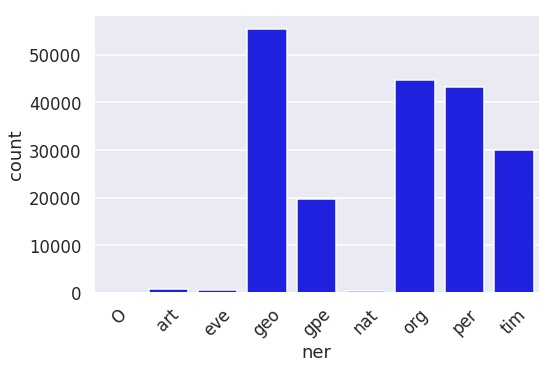

In [4]:
g = sns.catplot(x='ner', data=df[df.ner != 'O'], kind='count', aspect=1.5, color='b')
g.set_xticklabels(rotation=45);

### IOB-notation tags

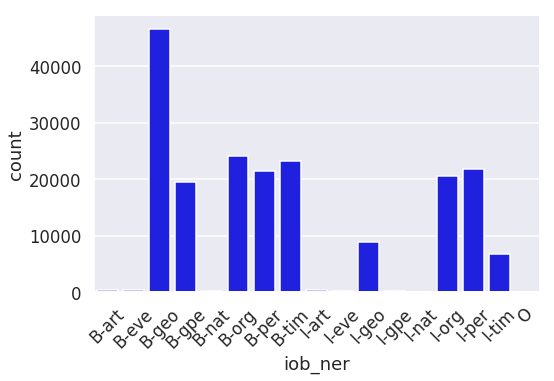

In [5]:
g = sns.catplot(x='iob_ner', data=df[df.ner != 'O'], kind='count', aspect=1.5, color='b')
g.set_xticklabels(rotation=45);

## Vocabulary overview

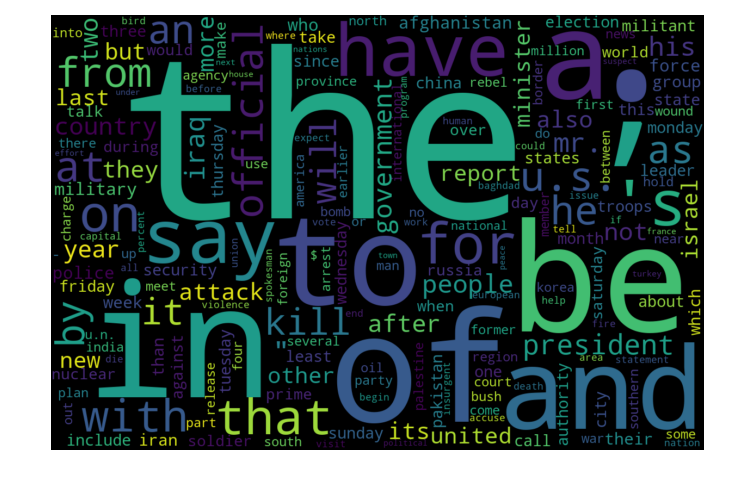

In [6]:
hw.get_wordcloud(df.lemma, SEED);

### Stop words removal

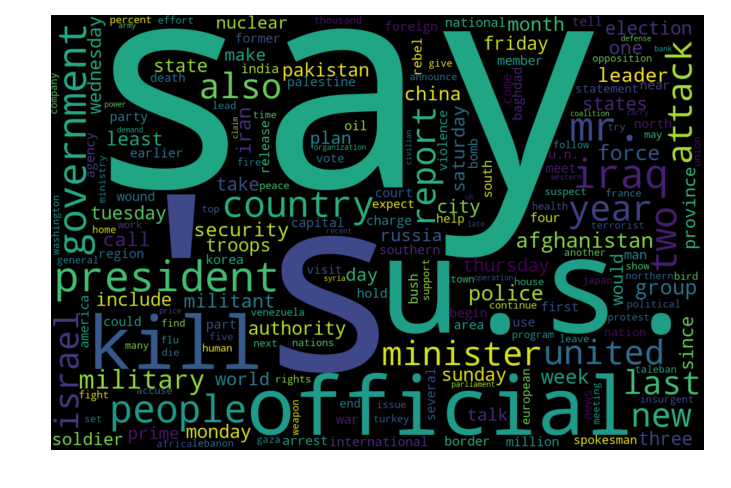

In [7]:
stopword_ind = hw.get_utility_token_index(df.lemma)
cleaned = df[~stopword_ind].copy()
hw.get_wordcloud(cleaned.lemma, SEED);

### Vocabulary size depending on token processing

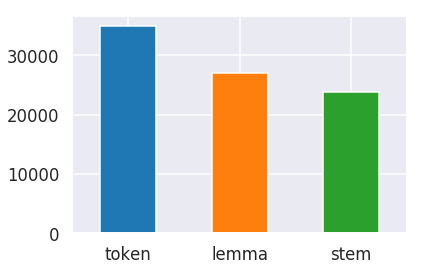

In [8]:
cleaned['stem'] = hw.get_stem(cleaned.lemma)
voc_size = pd.Series(data=np.array([len(cleaned.token.unique()), len(cleaned.lemma.unique()), len(cleaned.stem.unique())]), 
                     index=['token', 'lemma', 'stem'])
voc_size.plot(kind='bar', rot=0);

## POS-tags distribution over NER-tags

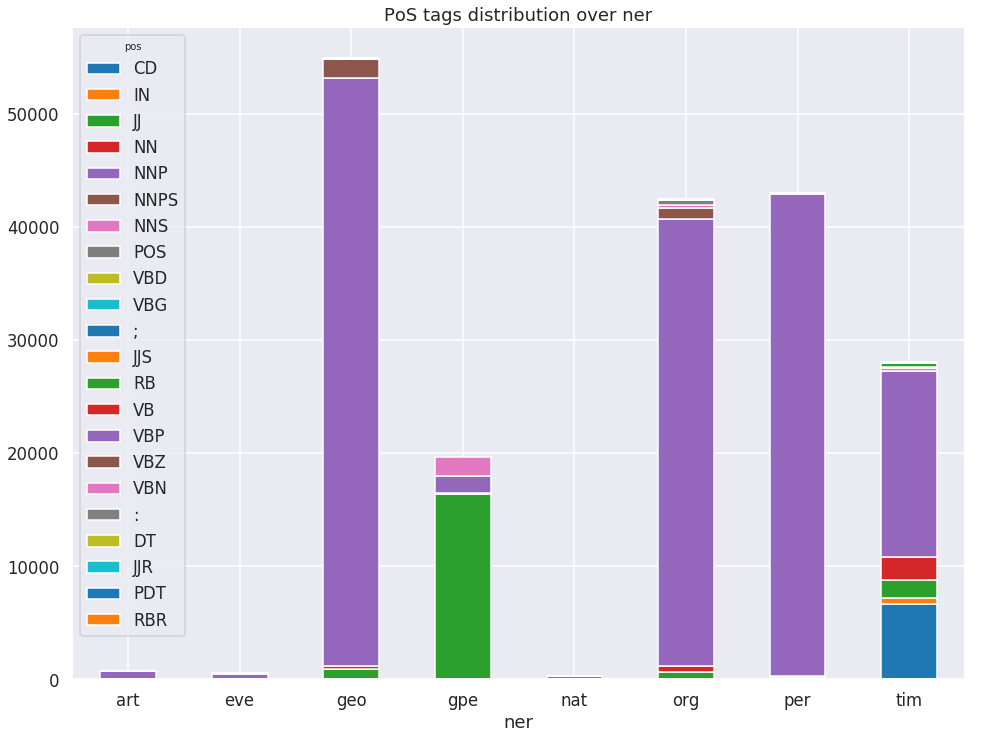

In [9]:
stacked_plot = cleaned[cleaned.ner != 'O'].groupby(['ner', 'pos']).size().reset_index().pivot(columns='pos', index='ner', values=0).fillna(0)
stacked_plot.plot(kind='bar', stacked=True, figsize=(16, 12), title='PoS tags distribution over ner', rot=0);

# Baseline model

## HMM

### Only token itself used as features

In [10]:
X, y, lengths = hw.get_X_y_lengths(cleaned, cols_to_keep={'token'}, one_hot=False)

In [11]:
class Mapping:
    def umap(self, x):
        return np.full_like(x, '<UNK>', dtype=object)

In [12]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelBinarizer


unknown_list = ['<UNK>']
num_classes = len(np.unique(y))
hmm = hw.CustomHMM(n_components=num_classes)
ohe = OneHotEncoder()
le = hw.UnknownWordsLabelEncoder(unknown_list, Mapping())

pipe = Pipeline([
    ('le', le),
    ('ohe', ohe),
    ('hmm', hmm)
])

In [ ]:
%%time
cv = hw.get_cv(lengths=lengths, seed=SEED, n_folds=9, yield_lengths=False)
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

bio_f1 = make_scorer(hw.get_bio_f1, label_mapping=cleaned.iob_ner)
cross_val_score(pipe, X, y, cv=cv, scoring=bio_f1, n_jobs=5, verbose=10)

[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................
[CV]  ................................................................


Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 405, in _handle_workers
    pool._maintain_pool()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 246, in _maintain_pool
    self._repopulate_pool()
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 239, in _repopulate_pool
    w.start()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 105, in start
    self._popen = self._Popen(self)
  File "/usr/lib/python3.6/multiprocessing/context.py", line 277, in _Popen
    return Popen(process_obj)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 19, in __init__
    self._launch(process_obj)
  File "/usr/lib/python3.6/multiprocessing/popen_fork.py", line 66, in _launch
    self.pid = os.fork(

[CV]  ................................................................
[CV] ....................... , score=0.5421448031041031, total= 2.0min
[CV]  ................................................................
[CV] ....................... , score=0.5356736002700307, total= 2.0min
[CV]  ................................................................


[Parallel(n_jobs=5)]: Done   2 out of   9 | elapsed:  4.9min remaining: 17.2min


[CV] ....................... , score=0.5259512683578105, total= 2.1min
[CV]  ................................................................


[Parallel(n_jobs=5)]: Done   3 out of   9 | elapsed:  7.0min remaining: 14.0min


[CV] ....................... , score=0.5277504911591355, total= 2.1min


[Parallel(n_jobs=5)]: Done   4 out of   9 | elapsed:  9.1min remaining: 11.3min


In [ ]:
%%time
cv = hw.get_cv(lengths=lengths, seed=SEED, n_folds=11, yield_lengths=True)
scores = [] 
for (train_ind, train_len, test_ind, test_len) in cv:
    hmm = hw.CustomHMM()
    x_train = X[train_ind]
    y_train = y[train_ind]
    hmm.fit(x_train, y=y_train, smoothing='add')
    
    x_test = X[test_ind]
    y_test = y[test_ind]
    y_pred = hmm.predict(x_test.toarray())
    
    f1 = hw.get_bio_f1(y_test, y_pred, cleaned.iob_ner)
    print(f"Current f1: {f1}")
    scores.append(f1)
    
    del x_train
    del y_train
    del x_test
    del y_test
    del y_pred
    gc.collect()
print(f"AVG cross-validation f1 score: {np.mean(scores)}")

### Stem + PoS + shape

In [ ]:
cleaned['shape'] = cleaned.token.map(hw.word_shape)

In [ ]:
X, y, lengths = hw.get_X_y_lengths(cleaned, cols_to_keep={'stem', 'pos', 'shape'}, one_hot=True)

In [ ]:
%%time
cv = hw.get_cv(lengths=lengths, seed=SEED, n_folds=11, yield_lengths=True)
scores = hw.hmm_cv(X, y, cv, cleaned.iob_ner)

### Stem + PoS + shape + suffix + prefix

In [ ]:
cleaned['prefix'] = cleaned['lemma'].str.slice(0, 3)
cleaned['suffix'] = cleaned['lemma'].str.slice(-3)

In [ ]:
X, y, lengths = hw.get_X_y_lengths(cleaned, cols_to_keep={'stem', 'pos', 'shape', 'prefix', 'suffix'}, one_hot=True)

In [ ]:
%%time
cv = hw.get_cv(lengths=lengths, seed=SEED, n_folds=11, yield_lengths=True)
scores = hw.hmm_cv(X, y, cv, cleaned.iob_ner)

### Add previous context

In [ ]:
prev_df = cleaned.loc[:, ['pos', 'sentence', 'shape', 'stem', 'lemma', 'seq', 'sentence']]
doc_begin_idx = prev_df.groupby('seq').head(1).index.values
prev.loc[doc_begin_idx, :] = 'BOS'
prev_df.head()

# CRF

In [ ]:
features, y, labels = hw.load_crf_features(CRF_FEATURES_PATH)
lengths = np.array(list(map(len, y)))

In [ ]:
features[0][0]

In [ ]:
crf = sklearn_crfsuite.CRF(algorithm='lbfgs', max_iterations=100, all_possible_transitions=True)
params = {'c1': [0.01], 'c2': [0.01]}
f1_scorer = make_scorer(hw.get_bio_f1, label_mapping=cleaned.iob_ner)
# search
rs = GridSearchCV(crf,
                  params,
                  cv=5,
                  verbose=10,
                  n_jobs=-1,
                  scoring=f1_scorer)
rs.fit(features, y)
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)

# NN